# Collect the data

Fill this [form](https://forms.gle/jc7c5arhkeHXhuFu7) to collect the data. Provide your id and answer the questions about your food preferences.

# Download the data

After everyone fills the form, download the data

In [1]:
googleSheetId = '1Tvdbm1_HzrvBY_veX0mCZkab9I8OD85IcijNlZB7hRI'
workSheetName = 'Form+responses+1'
URL = 'https://docs.google.com/spreadsheets/d/{0}/gviz/tq?tqx=out:csv&sheet={1}'.format(
    googleSheetId,
    workSheetName
)

In [2]:
import pandas as pd
import numpy as np
rawdf = pd.read_csv(URL)
rawdf

,Timestamp,Your ID (name/nickname),Food vs Estimations [Salty caramel],Food vs Estimations [Sweet pudding],Food vs Estimations [Milk chocolate],Food vs Estimations [Dark chocolate],Food vs Estimations [Donuts],Food vs Estimations [Baklava],Food vs Estimations [Fresh cucumber],Food vs Estimations [Pickles],...,Food vs Estimations [Bass (fish)],Food vs Estimations [Turkey],Food vs Estimations [Salmon],Food vs Estimations [Bananas],Food vs Estimations [Dates],Food vs Estimations [Pears],Food vs Estimations [Melon],Food vs Estimations [Oranges],Food vs Estimations [Watermelon],Food vs Estimations [Celery]
0,27/09/2021 14:13:23,Daddy Stasik,Neutral/Never tried,Neutral/Never tried,Neutral/Never tried,Like,Dislike,Neutral/Never tried,Neutral/Never tried,Like,...,Dislike,Like,Like,Like,Like,Like,Like,Neutral/Never tried,Neutral/Never tried,Dislike
1,27/09/2021 14:16:07,@startupfairy,Like,Like,Like,Dislike,Neutral/Never tried,Like,Neutral/Never tried,Like,...,Like,Like,Like,Like,Like,Like,Neutral/Never tried,Like,Like,Like
2,27/09/2021 14:19:38,TotallyNotGaponov,Like,Like,Like,Neutral/Never tried,Like,Like,Like,Like,...,Like,Like,Like,Like,Like,Like,Like,Like,Like,Dislike
3,27/09/2021 14:20:05,Stas Litvinov,Like,Neutral/Never tried,Neutral/Never tried,Like,Like,Like,Like,Like,...,Like,Like,Like,Like,Neutral/Never tried,Like,Like,Neutral/Never tried,Like,Like
4,27/09/2021 14:24:35,Bad Boy,Like,Like,Like,Dislike,Like,Dislike,Like,Dislike,...,Like,Like,Like,Dislike,Dislike,Dislike,Neutral/Never tried,Like,Like,Like


# Prepare the data

Extract 
1. array with numbers `M`
2. List of participants: `names`
3. List of food items `foods` and their short form `foods_short`

In [3]:
ranks = {
    "Like": 1., 
    "Dislike": -1., 
    "Neutral/Never tried": 0.0
}
df = rawdf.applymap(lambda x: ranks[x] if x in ranks else x, na_action='ignore')

names = df['Your ID (name/nickname)'].to_numpy()
foods = df.columns[2:].to_numpy()
foods_short =  [x[20:] for x in foods]
M = df[foods].to_numpy()

[]

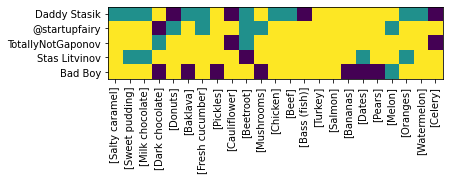

In [4]:
import matplotlib.pyplot as plt

ax = plt.gca()
plt.yticks(list(range(len(names))))
plt.xticks(list(range(len(foods_short))), rotation='vertical')
ax.set_yticklabels(names)
ax.set_xticklabels(foods_short)
plt.imshow(M)
plt.plot()

# What is the rank of the matrix?

In [5]:
matrix_rank = np.linalg.matrix_rank(M)
print(f"Matrix rank is {matrix_rank}. Latent space is not more than {matrix_rank}-dimensional.")

Matrix rank is 5. Latent space is not more than 5-dimensional.


# Let's find low-dimensional decomposition

Set the rank which you think can work in your case

In [6]:
RANK = 4

Find SVD decomposition. Remember, SVD preserves distance, while PCA - variance!

**WE NEED DISTANCE**

In [7]:
users_to_latent, s, latent_to_food = np.linalg.svd(M, full_matrices=True)

# representation in classic SVD definition NxM diagonal matrix
significance = np.zeros((users_to_latent.shape[1], latent_to_food.shape[0]))
significance[:min(*significance.shape), :min(*significance.shape)] = np.diag(s)

Representation of users in reduced 4-dimensional latent space


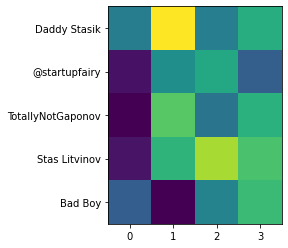

In [8]:
U = users_to_latent[:, :RANK] @ significance[:RANK, :RANK]
print(f"Representation of users in reduced {RANK}-dimensional latent space")
# print(U)
ax = plt.gca()
ax.set_yticks(list(range(len(names))))
ax.set_yticklabels(names)
plt.imshow(U)
plt.show()

How similar are we to each other?

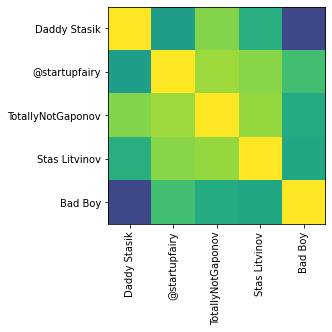

In [9]:
from sklearn.metrics.pairwise import cosine_similarity
U_similarity = cosine_similarity(U, U)
# print(U_similarity)
ax = plt.gca()
plt.yticks(list(range(len(names))))
plt.xticks(list(range(len(names))), rotation='vertical')
ax.set_yticklabels(names)
ax.set_xticklabels(names)
plt.imshow(U_similarity, vmax=1, vmin=-1)
plt.show()

# Ok, what about food representations in low-dimensional space?
They live on the last matrix, which should be transposed for uniform representation.

`.H` stands for Hermitian (transposed + complex conjugate). As our matrix is defined in real numbers this is equivalent to just transpose.

[]

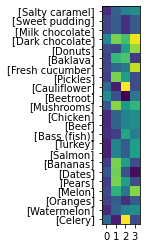

In [10]:
F = np.matrix(latent_to_food[:RANK, :]).H   # transposed complex conjugate
ax = plt.gca()
plt.xticks(list(range(RANK)))
ax.set_yticks(list(range(len(foods_short))))
ax.set_yticklabels(foods_short)
plt.imshow(F)
plt.plot()

How similar are foods to each other with respect to human's preferences?

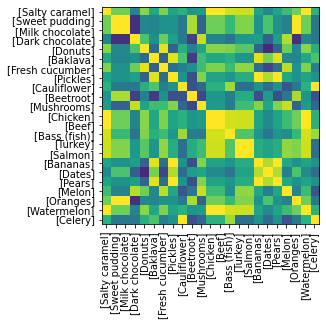

In [11]:
F_similarity = cosine_similarity(F, F)
ax = plt.gca()
plt.yticks(list(range(len(foods_short))))
plt.xticks(list(range(len(foods_short))), rotation='vertical')
ax.set_yticklabels(foods_short)
ax.set_xticklabels(foods_short)
plt.imshow(F_similarity, vmax=1, vmin=-1)
plt.show()

# And here come recommendations!

In [12]:
def recommend_to_user_from_database(name, names, U, database, database_labels):
    inames = dict((v, k) for k, v in enumerate(names))
    idx = inames[name]
    
    # similarities of a user vector to provided database
    sims = cosine_similarity([U[idx, :]], database)
    preferences = sims[0, :]
    
    # indices of a database items id descending order
    food_idx = np.argsort(preferences)[::-1]
    return [(preferences[n], database_labels[n]) for n in food_idx]

print("------- RECOMMEND SOME FOODS ------------")
print(*recommend_to_user_from_database("Daddy Stasik", names, U, F, foods_short), sep="\n")
print("------- RECOMMEND SOME FRIENDS ----------")
print(*recommend_to_user_from_database("Daddy Stasik", names, U, U, names), sep="\n")

------- RECOMMEND SOME FOODS ------------
(0.810749041236954, '[Mushrooms]')
(0.6907411717611991, '[Pickles]')
(0.6907411717611991, '[Pears]')
(0.6907411717611991, '[Bananas]')
(0.6307826823858956, '[Dates]')
(0.6280436358294791, '[Melon]')
(0.4369468677633225, '[Turkey]')
(0.4369468677633225, '[Salmon]')
(0.40330490352190035, '[Dark chocolate]')
(0.32934709352158736, '[Baklava]')
(0.07135571619864545, '[Fresh cucumber]')
(0.05187027567352159, '[Sweet pudding]')
(0.05187027567352156, '[Oranges]')
(0.05187027567352137, '[Milk chocolate]')
(-0.007260125675872087, '[Beef]')
(-0.007260125675872087, '[Chicken]')
(-0.007260125675872123, '[Watermelon]')
(-0.007260125675872198, '[Salty caramel]')
(-0.11963634120804739, '[Beetroot]')
(-0.26989337476285175, '[Donuts]')
(-0.42611357567376995, '[Bass (fish)]')
(-0.6799210883037929, '[Cauliflower]')
(-0.6799210883037929, '[Celery]')
------- RECOMMEND SOME FRIENDS ----------
(1.0000000000000002, 'Daddy Stasik')
(0.63109078278679, 'TotallyNotGaponov'

## TODO 
Save users and foods into the index structure and rewrite recommendation procedure

In [13]:
!pip install annoy

1. Build a search index. Refer to [documentation example](https://github.com/spotify/annoy#python-code-example).

In [14]:
from annoy import AnnoyIndex

n_dimensions = RANK
n_trees = 10

INDEX = AnnoyIndex(n_dimensions, 'angular')

# TODO complete the code, use n_trees = 10

2. Search in the index (rewrite search methods). Use `get_nns_by_vector(...)`, [refer to this paragraph](https://github.com/spotify/annoy#full-python-api). Use `n_neighbours = 10`.

In [15]:
# TODO